# Stochastic variability in the MWC model

In [1]:
# Our numerical workhorses
import numpy as np
from sympy import mpmath
import scipy.optimize
import scipy.special
import scipy.integrate
import pandas as pd
import itertools
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Seaborn, useful for graphics
import seaborn as sns

# Pickle is useful for saving outputs that are computationally expensive
# to obtain every time
import pickle

import os
import glob

# Import the utils for this project
import chann_cap_utils as chann_cap

chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/stochastic_mwc/'
tmpdir = '../../tmp/'

# Variability in the number of active repressors.

Since this project tries to take into account all the relevant variability sources in the regulation of a gene by a simple-repression architecture, in this notebook we will implement the variability due to the number of active repressors.

First presented by [Martins and Swain](http://journals.plos.org/ploscompbiol/article?id=10.1371%2Fjournal.pcbi.1002261), the MWC model can also be phrased in the language of chemical master equation. In the case of the *lac* repressor we know that the molecule can transition between an active state $A$ and an inactive state $I$. Let $A_k(t)$ and $I_k(t)$ be the random variables defining a repressor in the active and inactive state respectively, with $k$ ligands bound at time $t$.  

Let's define the time-dependent state vector of the system as

\begin{equation}
X(t) = \left[ A_2(t)\; A_1(t)\; A_0(t)\; I_0(t)\; I_1(t)\; I_2(t) \right]^T.
\end{equation}

Let $\Pi$ be the transition rate matrix, where $\Pi_{ij}$ with $i\neq j$ is the transition rate between states $i$ and $j$. For the case when $i=j$ we have that $\Pi_{ii} = - \sum_{j\neq i}\Pi_{ij}$. This allow us to write the time evolution of the probability of the state vector as

\begin{equation}
\frac{d}{dt}P_{X(t)} = \Pi \cdot P_{X(t)},
\end{equation}

Using this theoretical framework Martins and Swain derive the distribution of active repressors. What they found is, I think, what one would intuitively would have guess given the nature of the problem. Given a *total* number of repressors $R$ and an inducer concentration $c$ the probability of having $R_{act}$ repressors with $R_{act} \in {0, 1, \ldots R}$ is given by

\begin{equation}
P(R_{act} \mid R, C) = {R \choose R_{act}}p_{act}(c)^{R_{act}}\left(1 - p_{act}(c)\right)^{R - R_{act}},
\end{equation}
where $p_{act}$ is the thermodynamic MWC probability of having an active repressor, i.e.

\begin{equation}
p_{act}(c) = \frac{\left( 1 + \frac{c}{K_A} \right)^2}{\left( 1 + \frac{c}{K_A} \right)^2 + \omega \left( 1 + \frac{c}{K_I} \right)^2}.
\end{equation}

We can therefore think of the effect of the inducer as biasing a coin that each individual repressor would flip in order to determine its state.

# Implementing this variability into the channel capacity computation.

In order to implement this variability into our computation of the theoretical channel capacity let's first review our current model for computing the probability distribution of molecule $x$ (either mRNA or protein) given an inducer concentration and a repressor copy number $R$.

Recall that the effect of the repressor copy number and the inducer in the computation is capture in the $k_{on}$ rate where we assume that there is a linear relation between this rate and the number of repressors, i.e. $k_{on} \equiv k_0 [R]p_{act}(c)$, where $k_0$ is a diffusion limited rate.

If we now include the variability in the number of active repressors the computation of the probability of having $x$ molecules should now sum over all possible number of active repressors according to their probability distribution, this means that we have to compute

\begin{equation}
P(x \mid R, c) = \sum_{r=0}^R P(x\mid R_{act})P(R_{act} \mid R, c),
\end{equation}

where the second term on the right hand side of the equation is given by the binomial distribution we just showed.

If the computation of the probability now includes a weighted sum over all possible number of active repressors, it would be easy to use a pre-computed *lookup table* for the probability distribution of all possible number of repressors given the computational complexity of these calculations.

We have previously computed these tables for different operators (different $k_{off}$) where each row contains the probability distribution of a given molecule for a single repressor copy number.

Let's look at an example

In [56]:
filename = '../../data/csv_protein_dist/lnp_O2_DJ_RB.csv'
df = pd.read_csv(filename, header=0, index_col=0, comment='#')
df.head()

,lnp,prob,protein,repressor
0,-382.335379,0.0,0.0,0.0
1,-377.351782,0.0,1.0,0.0
2,-373.055138,0.0,2.0,0.0
3,-369.157804,0.0,3.0,0.0
4,-365.542035,0.0,4.0,0.0


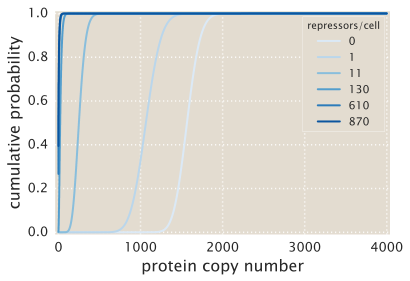

In [3]:
r_example = [0, 1, 11, 130, 610, 870]
colors = dict(zip(r_example, sns.color_palette('Blues', n_colors=len(r_example))))
for i, r in enumerate(r_example):
    data = df[df.repressor == r].sort_values(by='protein')
    plt.plot(data.protein, np.cumsum(data.prob), 
             drawstyle='steps', label=str(int(r)), color=colors[r])
plt.xlabel('protein copy number')
plt.ylabel('cumulative probability')
plt.legend(loc=0, title='repressors/cell')
plt.margins(0.01)

Let's now define a function that takes one of these lookup tables, an inducer concentration and a total repressor copy number and computes the weighted probability distribution.

In [53]:
def weight_prob(df_prob, Rtot, c, **kwargs):
    '''
    computes the weighted probability distribution of molecule x given the
    variability in the number of active repressors as a function of the total
    number of repressors and inducer concentration.
    NOTE : The matrices where pre-computed assuming some parameters for the
    MWC model. Make sure that you are using the same set of parameters otherwise
    the computation will not be the same.
    Parameters
    ----------
    df_prob : DataFrame.
        Pre-computed lookup table that contains the probability 
        distribution of molecule x for a given repressor copy number.
    Rtot : int.
        Total number of repressors / cell.
    c : array-like.
        concentration(s) at which evaluate the probability distributions.
    kwargs : dictionary.
        optional parameters to pass to the p_act function like:
        ka, ki : Dissociation constants for the active and inactive states 
        epsilon : Energetic barrier between the inactive and the active state. 
    Returns
    -------
    QxR_weight : array-like.
        Weighted probability distribution for each inducer concentration.
    '''
    # convert the concentrations into a numpy array
    c = np.array(c)
    
    # Generate an array for all possible number of active repressors
    R_array = np.arange(0, Rtot + 1)
    
    # compute pactives
    pacts = chann_cap.p_act(c, **kwargs)
    
    # Initialize matrix to save output
    Qgc = np.zeros([len(c), len(df_prob.protein.unique())])
    # Group by proteins
    df_prot = df_prob.groupby('protein')
    # Loop through pacts computing pact on each of them
    for i, p in enumerate(pacts):
        # Compute the probability of having each repressor active
        # given the stochastic MWC model
        # Initialize an array of zeros for probabilities of repressors
        pRact = np.zeros_like(df_prob.repressor.unique())
        # Compute the probabilities of the repressors being active
        pRact[0:(Rtot + 1)] = scipy.stats.binom.pmf(R_array, Rtot, p)
        # Compute the weighted probability for each protein
        Qgc[i,:] = df_prot.apply(func=lambda x: sum(x['prob'] * pRact)).values
    return Qgc

Having define the function to compute the weighted probability let's compare some examples to see how much this stochasticity affects the probability.

In [22]:
mwc_param = dict(ka=141.52, ki=0.56061, epsilon=4.5)

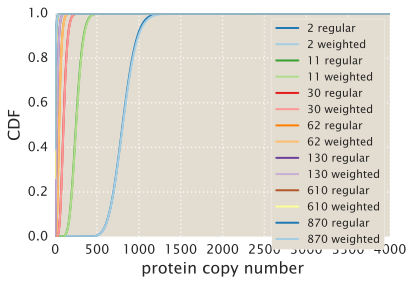

In [66]:
# Define the number of repressors to plot
R_array = [2, 11, 30, 62, 130, 610, 870]

# Define the colors for the plot
colors = sns.color_palette("Paired", len(R_array) * 2)

fig, ax = plt.subplots(1,1)
for i, r in enumerate(R_array):
    ax.plot(df.protein.unique(), np.cumsum(df[df.repressor==r].prob), 
         drawstyle='steps', color=colors[i * 2 + 1], 
         label=str(r) + ' regular')
    Qgc = weight_prob(df, c=[0], Rtot=r, **mwc_param)[0,:]
    ax.plot(df.protein.unique(), np.cumsum(Qgc), drawstyle='steps',
            color=colors[i * 2], label=str(r) + ' weighted')
ax.set_xlabel('protein copy number')
ax.set_ylabel('CDF')
# ax.set_xlim([0, 600])
ax.legend(loc=0)

We can see that as the number of repressors increases the difference bewtween the weighted PMF and the regular PMF become insignificant. This must be because these distributions were evaluated at an inducer concentration $c=0$. At this value $p_{act}$ is close to 1 and therefore the variability in the binomial distribution is relatively small. But as $p_{act} \rightarrow 0.5$ the variability in the number of active repressors must increase, reflecting this in the mRNA distribution.

Let's see how the inducer concentration affects the probability focusing on a single strain.

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0.0, 30)

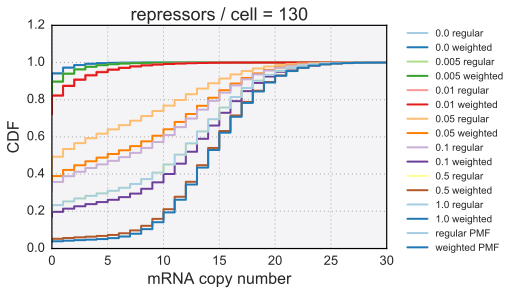

In [93]:
# Define the concentrations to evaluate
C_array = np.array([0, 5, 10, 50, 100, 500, 1000]) / 1E3

# Define the mRNA grid
m_grid = np.arange(0, QmR.shape[0])

# Define the colors for the plot
colors = sns.color_palette("Paired", len(C_array) * 2)

plt.figure()
r = 130
for i, c in enumerate(C_array):
    rdet = round(r * chann_cap.p_act(c, ka=0.199, ki=0.00064, omega=np.exp(-4.5)))
    plt.plot(m_grid, np.cumsum(QmR[m_grid, rdet+1]), drawstyle='steps',
             color=colors[i * 2], label=str(c) + ' regular')
    pweight = weight_prob(QmR, [c], r)
    plt.plot(m_grid, np.cumsum(pweight), drawstyle='steps',
            color=colors[i * 2 + 1], label=str(c) + ' weighted')
    
plt.plot([], [], color=colors[0], label='regular PMF', linestyle='-')
plt.plot([], [], color=colors[1], label='weighted PMF', linestyle='-')
plt.xlabel('mRNA copy number')
plt.ylabel('CDF')
plt.title('repressors / cell = {:d}'.format(r))
# plt.legend(loc=0, ncol=2, title=r'concentration $\mu$M')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.xlim(right=30)

Now here is quite clear that there are differences between the regular distributions and the weighted ones.

To have a complete picture of the effect let's do the same plot at the protein level.

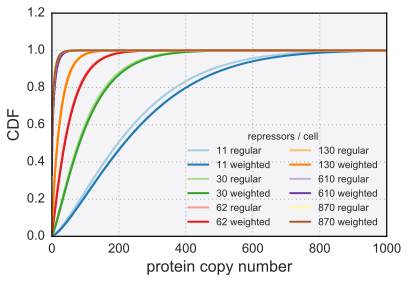

In [95]:
# Read the pre-computed protein distributions
QpR = np.loadtxt('../../tmp/QpR_O2_0_1050_noise_fit.csv',
                delimiter=',')[0:1001, :]

# Define the number of repressors to plot
R_array = [11, 30, 62, 130, 610, 870]
# Define the protein grid
p_grid = np.arange(0, QpR.shape[0])

# Define the colors for the plot
colors = sns.color_palette("Paired", len(R_array) * 2)

plt.figure()
for i, r in enumerate(R_array):
    plt.plot(p_grid, np.cumsum(QpR[p_grid, r+1]), drawstyle='steps',
            color=colors[i * 2], label=str(r) + ' regular')
    pweight = weight_prob(QpR, [0], r)
    plt.plot(p_grid, np.cumsum(pweight), drawstyle='steps',
            color=colors[i * 2 + 1], label=str(r) + ' weighted')
    
plt.xlabel('protein copy number')
plt.ylabel('CDF')
plt.legend(loc=0, ncol=2, title='repressors / cell')

Again at the protein level if the concentration of inducer is 0 there is no significant difference for different repressor copy numbers

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0.0, 2000)

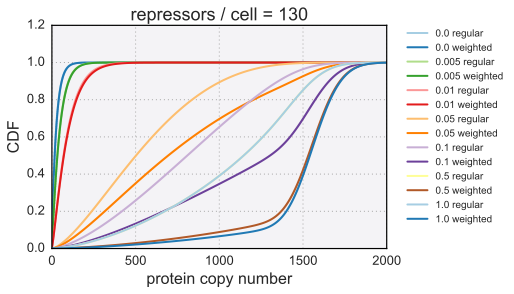

In [99]:
# Read the pre-computed protein distributions
QpR = np.loadtxt('../../tmp/QpR_O2_0_1050_noise_fit.csv',
                delimiter=',')

# Define the concentrations to evaluate
C_array = np.array([0, 5, 10, 50, 100, 500, 1000]) / 1E3

# Define the protein grid
p_grid = np.arange(0, QpR.shape[0])

# Define the colors for the plot
colors = sns.color_palette("Paired", len(C_array) * 2)

plt.figure()
r = 130
for i, c in enumerate(C_array):
    rdet = round(r * chann_cap.p_act(c, ka=0.199, ki=0.00064, omega=np.exp(-4.5)))
    plt.plot(p_grid, np.cumsum(QpR[p_grid, rdet+1]), drawstyle='steps',
             color=colors[i * 2], label=str(c) + ' regular')
    pweight = weight_prob(QpR, [c], r)
    plt.plot(p_grid, np.cumsum(pweight), drawstyle='steps',
            color=colors[i * 2 + 1], label=str(c) + ' weighted')
    
plt.xlabel('protein copy number')
plt.ylabel('CDF')
plt.title('repressors / cell = {:d}'.format(r))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.xlim(right=2000)

# Comparison at the channel capacity level.

To complete this story let's compare how does the MWC variability actually affects the channel capacity.

First let's read the experimental channel capacities

In [3]:
df_cc_exp = pd.read_csv(expdir + '20160830_channel_capacity_fdbins.csv',
                         index_col=0)

# Drop the channel capacities that came as infty
df_cc_exp = df_cc_exp[df_cc_exp.chan_cap!=np.inf]
df_cc_exp.head()

,date,run,rbs,operator,repressors,chan_cap
0,20160804,none,HG104,O2,11,0.663166
1,20160804,none,RBS1,O2,610,0.551492
2,20160804,none,RBS1027,O2,130,0.748831
3,20160804,none,RBS1147,O2,30,0.740433
4,20160804,none,RBS1L,O2,870,0.582959


### Channel capacity at the mRNA level

#### $k_0$ fit to experimental noise

In [5]:
# Define the parameters used to compute the lookup tables to save them along
# the channel capacity calculation
mRNA_param = {'gamma': 0.00284,
         'k0': 0.000123,
         'ka': 0.199,
         'ki': 0.00064,
         'omega': np.exp(-4.5),
         'r_gamma': 15.7}

# Define the concentrations to evaluate
C_array = np.array([0, 1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000]) / 1E3

kon_array = [chann_cap.kon_fn(-17, mRNA_param['k0']),
             chann_cap.kon_fn(-15.3, mRNA_param['k0']),
             chann_cap.kon_fn(-13.9, mRNA_param['k0']),
             chann_cap.kon_fn(-9.7, mRNA_param['k0'])]
# Define the operators names
operators = ['Oid', 'O1', 'O2', 'O3']



compute_capacity = False
if compute_capacity:
    df_chan_cap = pd.DataFrame()
    for i, op in enumerate(operators):
        print('operator : ' + op)
        # Read the pre-computed mRNA distributions
        QmR = np.loadtxt('../../tmp/QmR_' + op + '_0_1000_noise_fit.csv',
                delimiter=',')
        # Define the repressors to evaluate the function at
        R_array = np.arange(0, QmR.shape[1])
        # define a function to run in parallel the computation
        def capacity_parallel(r):
            mRNA_param['rep'] = r
            mRNA_param['kon'] = kon_array[i]
            QmC = weight_prob(QmR, C_array, r)
            return chann_cap.channel_capacity(QmC)[0]
        # Perform the parallel computation
        chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) \
                                        for r in R_array)
        # Save channel capacity and repressor copy number into a DataFrame
        df = pd.DataFrame(np.vstack([chan_cap, R_array]).T,
             columns=['channel_capacity', 'repressors'])
        # Append the values of the parameters to the DataFrame to make it tidy
        param_df = pd.DataFrame(np.tile(\
                          np.array([val for (key,val) in mRNA_param.items()]),
                          (len(R_array), 1)), 
                          columns=mRNA_param.keys())
        df = pd.concat([df, param_df], axis=1)
        df.to_csv(outputdir + 'capacity_mRNA_expIPTG_MWC_var_' + \
                  op + '.csv')

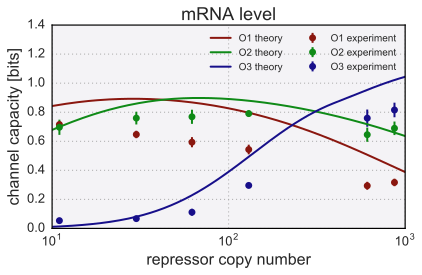

In [4]:
kon_operators = ['O1', 'O2', 'O3']

colors = sns.hls_palette(len(kon_operators), l=.3, s=.8)

fig = plt.figure()
# Load the saved data
for i, kon in enumerate(kon_operators):
    df = pd.read_csv(outputdir + 'capacity_mRNA_expIPTG_MWC_var_' + kon + '.csv')
    # plot the channel capacity
    plt.plot(df.repressors, df.channel_capacity, label=kon + ' theory',
            color=colors[i])
    # compute the mean value for each concentration
    cc_mean = df_cc_exp[df_cc_exp.operator==kon].\
              groupby('rbs').chan_cap.mean()
    # compute the standard error of the mean
    cc_err = df_cc_exp[df_cc_exp.operator==kon].\
              groupby('rbs').chan_cap.std() /\
    np.sqrt(df_cc_exp[df_cc_exp.operator==kon].groupby('rbs').size())
        
        # plot the experimental df_cc_exp
    plt.errorbar(df_cc_exp[df_cc_exp.operator==kon].groupby('rbs').\
                 repressors.unique(), cc_mean,
            yerr=cc_err, fmt='o', label=kon + ' experiment',
            color=colors[i])
    
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.legend(loc=0, ncol=2)
plt.title('mRNA level')
plt.xlim([10, 1E3])
plt.ylim([0, 1.4])
plt.tight_layout()

#### $k_0$ from Jones and Brewster Science paper

In [8]:
# Define the parameters used to compute the lookup tables to save them along
# the channel capacity calculation
mRNA_param = {'gamma': 0.00284,
         'k0': 2.7E-3,
         'ka': 0.199,
         'ki': 0.00064,
         'omega': np.exp(-4.5),
         'r_gamma': 15.7}

# Define the concentrations to evaluate
C_array = np.array([0, 1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000]) / 1E3

kon_array = [chann_cap.kon_fn(-17, mRNA_param['k0']),
             chann_cap.kon_fn(-15.3, mRNA_param['k0']),
             chann_cap.kon_fn(-13.9, mRNA_param['k0']),
             chann_cap.kon_fn(-9.7, mRNA_param['k0'])]
# Define the operators names
operators = ['Oid', 'O1', 'O2', 'O3']

compute_capacity = False
if compute_capacity:
    df_chan_cap = pd.DataFrame()
    for i, op in enumerate(operators):
        print('operator : ' + op)
        # Read the pre-computed mRNA distributions
        QmR = np.loadtxt('../../tmp/QmR_' + op + '_0_1000_literature_param.csv',
                delimiter=',')
        # Define the repressors to evaluate the function at
        R_array = np.arange(0, QmR.shape[1])
        # define a function to run in parallel the computation
        def capacity_parallel(r):
            mRNA_param['rep'] = r
            mRNA_param['kon'] = kon_array[i]
            QmC = weight_prob(QmR, C_array, r)
            return chann_cap.channel_capacity(QmC)[0]
        # Perform the parallel computation
        chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) \
                                        for r in R_array)
        # Save channel capacity and repressor copy number into a DataFrame
        df = pd.DataFrame(np.vstack([chan_cap, R_array]).T,
             columns=['channel_capacity', 'repressors'])
        # Append the values of the parameters to the DataFrame to make it tidy
        param_df = pd.DataFrame(np.tile(\
                          np.array([val for (key,val) in mRNA_param.items()]),
                          (len(R_array), 1)), 
                          columns=mRNA_param.keys())
        df = pd.concat([df, param_df], axis=1)
        df.to_csv(outputdir + 'capacity_mRNA_expIPTG_MWC_var_' + \
                  op + '_literature_param.csv')

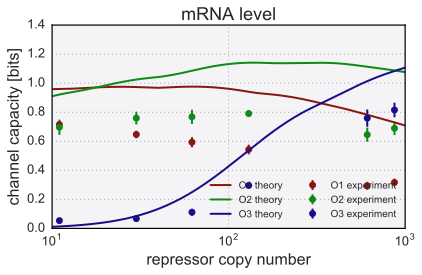

In [5]:
kon_operators = ['O1', 'O2', 'O3']

colors = sns.hls_palette(len(kon_operators), l=.3, s=.8)

fig = plt.figure()
# Load the saved data
for i, kon in enumerate(kon_operators):
    df = pd.read_csv(outputdir + 'capacity_mRNA_expIPTG_MWC_var_' + kon + \
                     '_literature_param.csv')
    # plot the channel capacity
    plt.plot(df.repressors, df.channel_capacity, label=kon + ' theory',
            color=colors[i])
    # compute the mean value for each concentration
    cc_mean = df_cc_exp[df_cc_exp.operator==kon].\
              groupby('rbs').chan_cap.mean()
    # compute the standard error of the mean
    cc_err = df_cc_exp[df_cc_exp.operator==kon].\
              groupby('rbs').chan_cap.std() /\
    np.sqrt(df_cc_exp[df_cc_exp.operator==kon].groupby('rbs').size())
        
        # plot the experimental df_cc_exp
    plt.errorbar(df_cc_exp[df_cc_exp.operator==kon].groupby('rbs').\
                 repressors.unique(), cc_mean,
            yerr=cc_err, fmt='o', label=kon + ' experiment',
            color=colors[i])
    
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.legend(loc=0, ncol=2)
plt.title('mRNA level')
plt.xlim([10, 1E3])
plt.ylim([0, 1.4])
plt.tight_layout()

## Channel capacity at the protein level

#### $k_0$ fit to experimental noise

In [6]:
# Protein parameters
k0=.000123 # Fit to the noise measurement of the O2 - RBS1027 data
prot_params = dict(ka=0.199, ki=0.00064, omega=np.exp(-4.5),
                   k0=k0,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=100)

In [7]:
# Define the concentrations to evaluate
C_array = np.array([0, 1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000]) / 1E3

kon_array = [chann_cap.kon_fn(-9.7, prot_params['k0'])]
# Define the operators names
operators = ['O3']

compute_capacity = True
if compute_capacity:
    df_chan_cap = pd.DataFrame()
    for i, op in enumerate(operators):
        print('operator : ' + op)
        # Read the pre-computed protein distributions
        QpR = np.loadtxt('../../tmp/QpR_' + op + '_0_1050_noise_fit.csv',
                delimiter=',')
        # Define the repressors to evaluate the function at
        R_array = np.arange(0, QpR.shape[1])
        # define a function to run in parallel the computation
        def capacity_parallel(r):
            prot_params['rep'] = r
            prot_params['kon'] = kon_array[i]
            QpC = weight_prob(QpR, C_array, r)
            return chann_cap.channel_capacity(QpC)[0]
        # Perform the parallel computation
        chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) \
                                        for r in R_array)
        # Save channel capacity and repressor copy number into a DataFrame
        df = pd.DataFrame(np.vstack([chan_cap, R_array]).T,
             columns=['channel_capacity', 'repressors'])
        # Append the values of the parameters to the DataFrame to make it tidy
        param_df = pd.DataFrame(np.tile(\
                          np.array([val for (key,val) in prot_params.items()]),
                          (len(R_array), 1)), 
                          columns=prot_params.keys())
        df = pd.concat([df, param_df], axis=1)
        df.to_csv(outputdir + 'capacity_protein_expIPTG_MWC_var_' + \
                  op + '.csv')

operator : O3


KeyboardInterrupt: 

In [ ]:
QpR = np.loadtxt('../../tmp/QpR_' + 'O3' + '_0_1050_noise_fit.csv',
                delimiter=',')

In [10]:
QpR_copy = np.zeros_like(QpR)
tmp = []
for i in np.arange(QpR.shape[1]):
    cum_sum = np.cumsum(QpR[:, i])
    tmp.append(np.any((cum_sum >= 1 - 0.03) & (cum_sum <= 1 + 0.02)))
#     idx = np.where((cum_sum >= 1 - 0.03) & (cum_sum <= 1 + 0.02))[0]
#     QpR_copy[0:idx[-1], i] = QpR[0:idx[-1], i]

In [44]:
trouble = np.where([not i for i in tmp])[0]

In [45]:
trouble

array([65, 66, 68])

(0.0, 1.05)

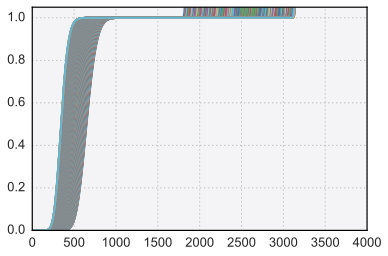

In [65]:
trouble = np.arange(200, 500)
plt.figure()
for t in trouble:
#     plt.plot(np.cumsum(QpR, axis=0)[t, :])
    plt.plot(np.cumsum(QpR[:, t]))
plt.ylim(top=1.05)

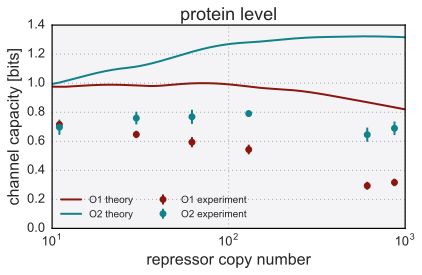

In [132]:
kon_operators = ['O1', 'O2']
colors = sns.hls_palette(len(kon_operators), l=.3, s=.8)

fig = plt.figure()
# Load the saved data
for i, kon in enumerate(kon_operators):
    df = pd.read_csv(outputdir + 'capacity_protein_expIPTG_MWC_var_' + kon +\
                     '.csv')
    # plot the channel capacity
    plt.plot(df.repressors, df.channel_capacity, label=kon + ' theory',
            color=colors[i])
    # compute the mean value for each concentration
    cc_mean = df_cc_exp[df_cc_exp.operator==kon].\
              groupby('rbs').chan_cap.mean()
    # compute the standard error of the mean
    cc_err = df_cc_exp[df_cc_exp.operator==kon].\
              groupby('rbs').chan_cap.std() /\
    np.sqrt(df_cc_exp[df_cc_exp.operator==kon].groupby('rbs').size())
        
        # plot the experimental df_cc_exp
    plt.errorbar(df_cc_exp[df_cc_exp.operator==kon].groupby('rbs').\
                 repressors.unique(), cc_mean,
            yerr=cc_err, fmt='o', label=kon + ' experiment',
            color=colors[i])
    
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.legend(loc=0, ncol=2)
plt.title('protein level')
plt.xlim([10, 1E3])
plt.tight_layout()

#### $k_0$ from Jones and Brewster Science paper

In [135]:
# Protein parameters
k0= 2.7E-3 # Fit to the noise measurement of the O2 - RBS1027 data
prot_params = dict(ka=0.199, ki=0.00064, omega=np.exp(-4.5),
                   k0=k0,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=100)

In [136]:
# Define the concentrations to evaluate
C_array = np.array([0, 1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000]) / 1E3

kon_array = [chann_cap.kon_fn(-13.9, prot_params['k0'])]
# Define the operators names
operators = ['O2']



compute_capacity = True
if compute_capacity:
    df_chan_cap = pd.DataFrame()
    for i, op in enumerate(operators):
        print('operator : ' + op)
        # Read the pre-computed protein distributions
        QpR = np.loadtxt('../../tmp/QpR_' + op + '_0_1050_noise_fit.csv',
                delimiter=',')
        # Define the repressors to evaluate the function at
        R_array = np.arange(0, QpR.shape[1])
        # define a function to run in parallel the computation
        def capacity_parallel(r):
            prot_params['rep'] = r
            prot_params['kon'] = kon_array[i]
            QpC = weight_prob(QpR, C_array, r)
            return chann_cap.channel_capacity(QpC)[0]
        # Perform the parallel computation
        chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) \
                                        for r in R_array)
        # Save channel capacity and repressor copy number into a DataFrame
        df = pd.DataFrame(np.vstack([chan_cap, R_array]).T,
             columns=['channel_capacity', 'repressors'])
        # Append the values of the parameters to the DataFrame to make it tidy
        param_df = pd.DataFrame(np.tile(\
                          np.array([val for (key,val) in prot_params.items()]),
                          (len(R_array), 1)), 
                          columns=prot_params.keys())
        df = pd.concat([df, param_df], axis=1)
        df.to_csv(outputdir + 'capacity_protein_expIPTG_MWC_var_' + \
                  op + '_literature_param.csv')

operator : O2


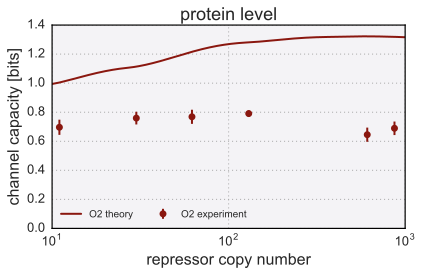

In [137]:
kon_operators = ['O2']
colors = sns.hls_palette(len(kon_operators), l=.3, s=.8)

fig = plt.figure()
# Load the saved data
for i, kon in enumerate(kon_operators):
    df = pd.read_csv(outputdir + 'capacity_protein_expIPTG_MWC_var_' + kon +\
                     '_literature_param.csv')
    # plot the channel capacity
    plt.plot(df.repressors, df.channel_capacity, label=kon + ' theory',
            color=colors[i])
    # compute the mean value for each concentration
    cc_mean = df_cc_exp[df_cc_exp.operator==kon].\
              groupby('rbs').chan_cap.mean()
    # compute the standard error of the mean
    cc_err = df_cc_exp[df_cc_exp.operator==kon].\
              groupby('rbs').chan_cap.std() /\
    np.sqrt(df_cc_exp[df_cc_exp.operator==kon].groupby('rbs').size())
        
        # plot the experimental df_cc_exp
    plt.errorbar(df_cc_exp[df_cc_exp.operator==kon].groupby('rbs').\
                 repressors.unique(), cc_mean,
            yerr=cc_err, fmt='o', label=kon + ' experiment',
            color=colors[i])
    
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.legend(loc=0, ncol=2)
plt.title('protein level')
plt.xlim([10, 1E3])
plt.tight_layout()